## Custom Dataset
1. `신규범 캠퍼님 코드 참조` : 사진 하나하나 레이블링해서 csv파일로 저장
2. Dataset 모듈

In [2]:
import os
import pandas as pd
from PIL import Image 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import random

import torch 
import torchvision 
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

### 이미지 데이터를 Class 18개로 레이블링한 데이터프레임 생성

In [3]:
"""
신규범 캠퍼님 코드 참조

한번 실행했으면 주석처리 하셈
"""

# train_df = pd.read_csv('../input/data/train/train.csv')

# df = pd.DataFrame(None, columns = ['path', 'label'])
# train_dir = '../input/data/train/images'
# out_path = '../workspace/train_label.csv'

# def age_group(x):
#     if x < 30:
#         return 0
#     elif x < 60:
#         return 1
#     else:
#         return 2

# for index, line in enumerate(train_df.iloc):
#     for file in list(os.listdir(os.path.join(train_dir, line['path']))):
#         if file[0] == '.':
#             continue
#         if file.split('.')[0] == 'normal':
#             mask = 2
#         elif file.split('.')[0] == 'incorrect_mask':
#             mask = 1
#         else:
#             mask = 0
#         gender = 0 if line['gender'] == 'male' else 1
#         data = {
#             'path': os.path.join(train_dir, line['path'], file),
#             'label': mask * 6 + gender * 3 + age_group(line['age'])
#         }
#         df = df.append(data, ignore_index=True)

# df.to_csv(out_path)

In [4]:
df = pd.read_csv('train_label.csv')
df.head(5)

,Unnamed: 0,path,label
0,0,../input/data/train/images/000001_female_Asian...,4
1,1,../input/data/train/images/000001_female_Asian...,4
2,2,../input/data/train/images/000001_female_Asian...,4
3,3,../input/data/train/images/000001_female_Asian...,10
4,4,../input/data/train/images/000001_female_Asian...,4


### Custom Dataset 생성
- Transform도 위에 정의함
    - CenterCrop()으로 사이즈 조절 (어차피 정면 얼굴 사진이니까 centercrop 사용)
    - ToTensor()

In [6]:
# Transform Compose
data_transform = transforms.Compose([
    transforms.CenterCrop(320),
    transforms.ToTensor(),
])
# albumentation 

# Custom Dataset 생성
class CustomDataset(Dataset):
    # 초기 데이터 생성 방법을 지정
    def __init__(self, df, transforms=None):
        self.df = df
        self.image_data = self.df['path']   # x data, 이미지
        self.image_label = self.df['label'] # y data, 레이블

        self.transform = transforms

    # 데이터 전체 길이
    def __len__(self):
        return len(self.image_label)

    # 인덱스 주었을 때 반환되는 데이터의 형태
    def __getitem__(self, idx):
        image = Image.open(self.image_data[idx])

        if self.transform:
            image = self.transform(image)

        return image, self.image_label[idx]

데이터셋 만들고 개수 확인

In [7]:
train_data = CustomDataset(df, data_transform)
print(len(train_data))

18900


샘플 데이터 불러서 시각화  

Tensor 이미지를 numpy로 변환 후에 plt.imshow()를 해야함

torch.Size([3, 320, 320]) 0


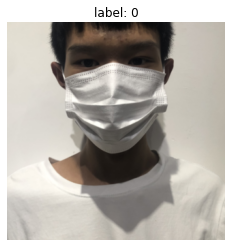

In [8]:
img, label = train_data[random.randint(0, len(train_data))]
print(img.shape, label)

img = np.array(img)
img = np.transpose(img, (1,2,0))
plt.imshow(img)
plt.title(f'label: {label}')
plt.axis('off')
plt.show()

(512, 384)


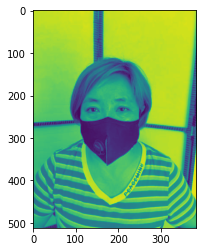

In [29]:
# convert('L')을 사용하면 흑백 이미지로 출력할 수 있음
img = Image.open('../input/data/train/images/000001_female_Asian_45/mask1.jpg').convert('L')
img = np.array(img)
print(img.shape)
plt.imshow(img)
plt.show()

샘플 이미지 여러장 출력

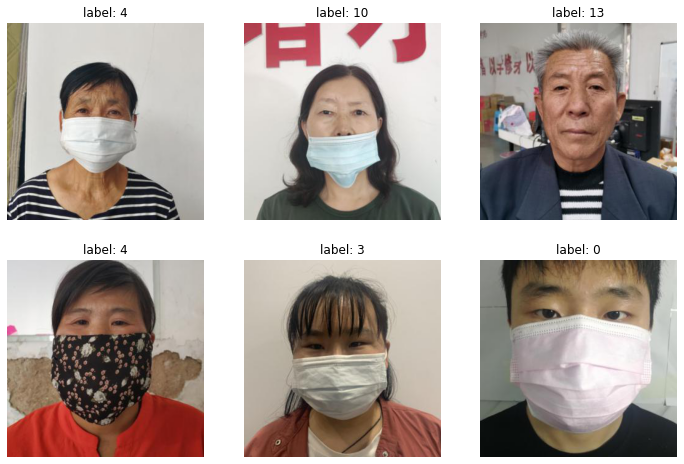

In [9]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    img, label = train_data[random.randint(0, len(train_data))]
    # print(img.shape, label)

    img = np.array(img)
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.title(f'label: {label}')
    plt.axis('off')

### DataLoader

In [10]:
dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)


In [11]:
first_batch = next(iter(dataloader))
print(first_batch[0].shape)
print(first_batch[1])

torch.Size([32, 3, 320, 320])
tensor([ 1,  4,  0, 16,  0,  0,  0,  4, 15,  6,  0,  1,  3, 12,  3,  4,  3,  4,
         0,  4,  4,  3,  3,  5,  2,  9,  4,  4, 16,  0,  4,  0])


In [13]:
first_batch[0][0].shape

torch.Size([3, 320, 320])

## ImageFolder 형식으로 데이터 만들기

In [30]:
df = pd.read_csv('train_label.csv')
df.sample(5)

,Unnamed: 0,path,label
9829,9829,../input/data/train/images/003444_female_Asian...,4
3967,3967,../input/data/train/images/001195_female_Asian...,3
12519,12519,../input/data/train/images/004244_female_Asian...,11
3269,3269,../input/data/train/images/001091_female_Asian...,3
12666,12666,../input/data/train/images/004269_male_Asian_5...,7


In [57]:
## Image Folder 형식으로 데이터 저장
# # classes = [i for i in range(18)]

# for index, i in enumerate(df.iloc):
#     # 이미지 정보를 배열에 담기 
#     img = Image.open(i['path']) 
#     # img = np.asarray(img) 
#     # img = Image.fromarray((img * 255).astype(np.uint8)) 
#     saved = 'image_folder/' + str(classes[i['label']]) + '/' + str(index) + '.jpg'
#     img.save(saved)

